# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

# Reading Data into dataframe

In [3]:
data = pd.read_csv('/Users/arfatshaikh/Documents/Machine-Learning/Logistic Regression/dataset/loantap.csv')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [6]:
data.shape

(396030, 27)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [8]:
data.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [9]:
for i in data.columns:
    if data[i].dtype == 'object':
        print(i)
        print(data[i].unique())
        print("--------"*20)

term
[' 36 months' ' 60 months']
----------------------------------------------------------------------------------------------------------------------------------------------------------------
grade
['B' 'A' 'C' 'E' 'D' 'F' 'G']
----------------------------------------------------------------------------------------------------------------------------------------------------------------
sub_grade
['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1' 'F3' 'G5' 'G4' 'F2' 'G3']
----------------------------------------------------------------------------------------------------------------------------------------------------------------
emp_title
['Marketing' 'Credit analyst ' 'Statistician' ...
 "Michael's Arts & Crafts" 'licensed bankere' 'Gracon Services, Inc']
---------------------------------------------------------------------------------------------------------------------------------

In [10]:
data['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [11]:
data['home_ownership'] = np.where(data['home_ownership'].isin(['ANY', 'NONE']), "OTHER", data['home_ownership'])

# Data Cleansing

In [12]:
data['term'].replace({' 36 months': 36, ' 60 months': 60}, inplace=True)

Unique patterns in address field
[
    '0174 Michelle Gateway\r\nMendozaberg, OK 22690',
    'USCGC Roth\r\nFPO AA 70466',
    'Unit 8386 Box 5821\r\nDPO AE 05113',
    'USNV Trujillo\r\nFPO AA 30723',
    'PSC 5108, Box 2953\r\nAPO AP 05113',
    'USS Ramirez\r\nFPO AP 29597',
    'USNS Roberts\r\nFPO AA 11650'
]

In [13]:
def split_address(addr):
    match = re.match(r'(?P<house_no>\d+)\s+(?P<first_add>.*?)\r\n(?P<second_add>.*?),\s+(?P<state>[A-Z]+)\s+(?P<zipcode>\d+)', addr)
    if match:
        return pd.Series(match.groupdict())
    return pd.Series([None]*5, index=['house_no', 'first_add', 'second_add', 'state', 'zipcode'])

In [14]:
data['address'] = data['address'].astype(str)

In [15]:
print(data['address'].head())  # Check the first few rows
print(data['address'].dtype)  # Check the data type
print(data['address'].isnull().sum())  # Check for null values

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object
object
0


In [16]:
address_split = data['address'].apply(split_address)

In [17]:
data = pd.concat([data, address_split], axis=1)

In [18]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,house_no,first_add,second_add,state,zipcode
0,10000.0,36,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",0174,Michelle Gateway,Mendozaberg,OK,22690
1,8000.0,36,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",1076,Carney Fort Apt. 347,Loganmouth,SD,05113
2,15600.0,36,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",87025,Mark Dale Apt. 269,New Sabrina,WV,05113
3,7200.0,36,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813",823,Reid Ford,Delacruzside,MA,00813
4,24375.0,60,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650",679,Luna Roads,Greggshire,VA,11650


In [19]:
data.loc[data['emp_title'].isna(), ['emp_title']] = 'Unknown'

In [20]:
data.loc[data['title'].isna(), ['title']] = 'Unknown'

In [21]:
data.loc[data['emp_length'].isna(), ['emp_length']] = 'Unknown'

USCGC Nunez\r\nFPO AE 30723,
Unit 8386 Box 5821\r\nDPO AE 05113,
USNV Trujillo\r\nFPO AA 30723,
PSC 5108, Box 2953\r\nAPO AP 05113,
USS Goodman\r\nFPO AE 22690,
USNS Roberts\r\nFPO AA 11650

In [22]:
def pattern2(addr):
    pattern = (
    r'(?P<house_no>[A-Za-z0-9,]+(?:\s+[A-Za-z0-9,]+)*)'  # house_no: allows letters, numbers, spaces, and commas
    r'\s+(?P<first_add>Box\s+\d+)'                       # first_add: Box number (e.g., Box 2953)
    r'\r\n(?P<second_add>[A-Za-z]{3})'                   # second_add: military type (e.g., APO)
    r'\s+(?P<state>[A-Z]{2})'                            # state code (e.g., AP)
    r'\s+(?P<zipcode>\d{5})'                             # 5-digit zip code
)

    # Apply regex to extract the parts
    match = re.match(pattern, addr)
    if match:
        result = match.groupdict()
        result['first_add'] = result['first_add'] if result['first_add'] else ''
        return pd.Series(result)
    return pd.Series([None]*5, index=['house_no', 'first_add','second_add', 'state', 'zipcode'])

In [23]:
def pattern3(addr):
    pattern = (
    r'(?P<house_no>[A-Za-z0-9]+)'                    # house_no: first word only (e.g., USNV)
    r'\s+(?P<first_add>[^\r\n]+)'                    # first_add: until newline (e.g., Trujillo)
    r'\r\n(?P<second_add>[A-Za-z]{3})'               # second_add: FPO/DPO/APO
    r'\s+(?P<state>[A-Z]{2})\s+(?P<zipcode>\d{5})'   # state and 5-digit zip
)

    # Apply regex to extract the parts
    match = re.match(pattern, addr)
    if match:
        result = match.groupdict()
        result['first_add'] = result['first_add'] if result['first_add'] else ''
        return pd.Series(result)
    return pd.Series([None]*5, index=['house_no', 'first_add','second_add', 'state', 'zipcode'])

In [24]:
data.loc[data['address'].str.split(' ').str[0].isin(['Unit','PSC']),'address'].apply(pattern2)

,house_no,first_add,second_add,state,zipcode
19,Unit 8386,Box 5821,DPO,AE,05113
26,Unit 3166,Box 1862,DPO,AE,48052
39,"PSC 5108,",Box 2953,APO,AP,05113
45,"PSC 7168,",Box 4065,APO,AA,22690
111,Unit 4847,Box 9014,DPO,AE,29597
...,...,...,...,...,...
395995,"PSC 0897,",Box 0320,APO,AP,22690
395997,"PSC 0473,",Box 7813,APO,AP,22690
396010,"PSC 9340,",Box 6659,APO,AA,05113
396012,Unit 3583,Box 8426,DPO,AP,29597


In [25]:
# Apply the pattern function to rows where 'house_no' is None and 'address' starts with 'USCGC'
uscgc_rows = data.loc[data['address'].str.split(' ').str[0].isin(['Unit','PSC'])]
updated_values = uscgc_rows['address'].apply(pattern2)

# Update the columns with the extracted values where they are None
for col in ['house_no', 'first_add', 'second_add', 'state', 'zipcode']:
    data.loc[data['address'].str.split(' ').str[0].isin(['Unit','PSC']), col] = data.loc[data['address'].str.split(' ').str[0].isin(['Unit','PSC']), col].fillna(updated_values[col])

In [26]:
data.loc[data['address'].str.split(' ').str[0].isin(['USNV','USS','USCGC','USNS']),'address'].apply(pattern3)

,house_no,first_add,second_add,state,zipcode
7,USCGC,Nunez,FPO,AE,30723
8,USCGC,Tran,FPO,AP,22690
33,USNV,Trujillo,FPO,AA,30723
62,USS,Goodman,FPO,AE,22690
92,USCGC,Hamilton,FPO,AA,48052
...,...,...,...,...,...
395900,USNS,Taylor,FPO,AE,29597
395903,USNV,Mills,FPO,AE,70466
395917,USS,Wright,FPO,AP,48052
395925,USNS,Rodriguez,FPO,AA,05113


In [27]:
# Apply the pattern function to rows where 'house_no' is None and 'address' starts with 'USCGC'
uscgc_rows = data.loc[data['address'].str.split(' ').str[0].isin(['USNV','USS','USCGC','USNS'])]
updated_values = uscgc_rows['address'].apply(pattern3)

# Update the columns with the extracted values where they are None
for col in ['house_no', 'first_add', 'second_add', 'state', 'zipcode']:
    data.loc[data['address'].str.split(' ').str[0].isin(['USNV','USS','USCGC','USNS']), col] = data.loc[data['address'].str.split(' ').str[0].isin(['USNV','USS','USCGC','USNS']), col].fillna(updated_values[col])

In [28]:
data.loc[data['revol_util'].isna(), ['revol_util']] = 0

In [29]:
data.loc[data['mort_acc'].isna(), ['mort_acc']] = 0

In [30]:
data.loc[data['pub_rec_bankruptcies'].isna(), ['pub_rec_bankruptcies']] = 0

In [31]:
data.isna().sum()  

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_title               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
title                   0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
house_no                0
first_add               0
second_add              0
state                   0
zipcode                 0
dtype: int64

In [32]:
data.drop('address', axis=1, inplace=True)

In [33]:
data['pub_rec'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  6.,  5.,  8.,  9., 10., 11.,  7., 19.,
       13., 40., 17., 86., 12., 24., 15.])

In [34]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    else:
        return 1


def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    else:
        return 1

In [35]:
data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['mort_acc'] = data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

In [36]:
data['title'] = data.title.str.lower()

In [37]:
data['initial_list_status'] = data['initial_list_status'].map({'f': 0, 'w': 1})

# Outlier treatement

In [38]:
def detect_outliers_iqr(df, column):
    """
    Detects outliers using the IQR method for a given column.
    
    Returns:
    - mask of outliers (boolean Series)
    - percentage of outliers in that column
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Boolean mask for outliers
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    outlier_count = outliers.sum()
    total_count = df[column].notna().sum()
    
    outlier_percentage = (outlier_count / total_count) * 100

    print(f"Outliers in '{column}': {outlier_count} out of {total_count} ({outlier_percentage:.2f}%)")
    
    return outliers, outlier_percentage


In [39]:
for i in data.columns:
    if data[i].dtype == 'int64' or data[i].dtype == 'float64':
        outliers, percentage = detect_outliers_iqr(data, i)

Outliers in 'loan_amnt': 191 out of 396030 (0.05%)
Outliers in 'term': 94025 out of 396030 (23.74%)
Outliers in 'int_rate': 3777 out of 396030 (0.95%)
Outliers in 'installment': 11250 out of 396030 (2.84%)
Outliers in 'annual_inc': 16700 out of 396030 (4.22%)
Outliers in 'dti': 275 out of 396030 (0.07%)
Outliers in 'open_acc': 10307 out of 396030 (2.60%)
Outliers in 'pub_rec': 57758 out of 396030 (14.58%)
Outliers in 'revol_bal': 21259 out of 396030 (5.37%)
Outliers in 'revol_util': 12 out of 396030 (0.00%)
Outliers in 'total_acc': 8499 out of 396030 (2.15%)
Outliers in 'initial_list_status': 0 out of 396030 (0.00%)
Outliers in 'mort_acc': 0 out of 396030 (0.00%)
Outliers in 'pub_rec_bankruptcies': 45115 out of 396030 (11.39%)


In [ ]:
#for col in data.columns:
#    if data[col].dtype == 'int64' or data[col].dtype == 'float64':
#        mean = data[col].mean()
#        std = data[col].std()
#        upper_limit = mean+3*std
#        lower_limit = mean-3*std
#        data = data[(data[col]<upper_limit) & (data[col]>lower_limit)]
#data.shape

(374562, 31)

In [40]:
data[['loan_amnt','installment','annual_inc','revol_bal','revol_util','dti']].describe()

,loan_amnt,installment,annual_inc,revol_bal,revol_util,dti
count,396030.000000,396030.000000,3.960300e+05,3.960300e+05,396030.000000,396030.000000
mean,14113.888089,431.849698,7.420318e+04,1.584454e+04,53.754260,17.379514
std,8357.441341,250.727790,6.163762e+04,2.059184e+04,24.484857,18.019092
min,500.000000,16.080000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8000.000000,250.330000,4.500000e+04,6.025000e+03,35.800000,11.280000
50%,12000.000000,375.430000,6.400000e+04,1.118100e+04,54.800000,16.910000
75%,20000.000000,567.300000,9.000000e+04,1.962000e+04,72.900000,22.980000
max,40000.000000,1533.810000,8.706582e+06,1.743266e+06,892.300000,9999.000000


In [41]:
#clipping the outliers to 99 percentile values
data['loan_amnt'] = np.where(data['loan_amnt'] > 35000, 35000, data['loan_amnt'])
data['installment'] = np.where(data['installment'] > 1000, 1000, data['installment'])
data['annual_inc'] = np.where(data['annual_inc'] > 150000.0, 150000.0, data['annual_inc'])
data['revol_bal'] = np.where(data['revol_bal'] > 40000, 40000, data['revol_bal'])
data['revol_util'] = np.where(data['revol_util'] > 100, 100, data['revol_util'])
data['dti'] = np.where(data['dti'] > 36, 36, data['dti'])

In [42]:
for i in ['loan_amnt','installment','annual_inc','revol_bal','revol_util','dti']:
    if data[i].dtype == 'int64' or data[i].dtype == 'float64':
        outliers, percentage = detect_outliers_iqr(data, i)

Outliers in 'loan_amnt': 0 out of 396030 (0.00%)
Outliers in 'installment': 0 out of 396030 (0.00%)
Outliers in 'annual_inc': 0 out of 396030 (0.00%)
Outliers in 'revol_bal': 0 out of 396030 (0.00%)
Outliers in 'revol_util': 0 out of 396030 (0.00%)
Outliers in 'dti': 0 out of 396030 (0.00%)


grade                       7
sub_grade                  35
emp_title              173106
emp_length                 12
home_ownership              4
verification_status         3
issue_d                   115
loan_status                 2
purpose                    14
title                   41327
earliest_cr_line          684
application_type            3
house_no                95452
first_add              286091
second_add              67513
state                      54
zipcode                    10
dtype: int64

# Feature Engineering

In [46]:
data.drop(columns=['issue_d','earliest_cr_line'],inplace=True)

In [47]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,house_no,first_add,second_add,state,zipcode
0,10000.0,36,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Fully Paid,vacation,vacation,26.24,16.0,0,36369.0,41.8,25.0,1,INDIVIDUAL,0,0,0174,Michelle Gateway,Mendozaberg,OK,22690
1,8000.0,36,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Fully Paid,debt_consolidation,debt consolidation,22.05,17.0,0,20131.0,53.3,27.0,0,INDIVIDUAL,1,0,1076,Carney Fort Apt. 347,Loganmouth,SD,05113
2,15600.0,36,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Fully Paid,credit_card,credit card refinancing,12.79,13.0,0,11987.0,92.2,26.0,0,INDIVIDUAL,0,0,87025,Mark Dale Apt. 269,New Sabrina,WV,05113
3,7200.0,36,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Fully Paid,credit_card,credit card refinancing,2.60,6.0,0,5472.0,21.5,13.0,0,INDIVIDUAL,0,0,823,Reid Ford,Delacruzside,MA,00813
4,24375.0,60,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Charged Off,credit_card,credit card refinance,33.95,13.0,0,24584.0,69.8,43.0,0,INDIVIDUAL,1,0,679,Luna Roads,Greggshire,VA,11650


In [48]:
data['loan_status'] = data['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

In [49]:
data['loan_status'].value_counts()

0    318357
1     77673
Name: loan_status, dtype: int64

In [50]:
data.select_dtypes(include=['object']).nunique()

grade                       7
sub_grade                  35
emp_title              173106
emp_length                 12
home_ownership              4
verification_status         3
purpose                    14
title                   41327
application_type            3
house_no                95452
first_add              286091
second_add              67513
state                      54
zipcode                    10
dtype: int64

In [67]:
label_encoding_columns = ['grade','sub_grade','emp_length','title','house_no','first_add','second_add','state','emp_title']
one_hot_encoding_columns = ['home_ownership','verification_status','purpose','zipcode','application_type']

In [52]:
for i in label_encoding_columns:
    if data[i].dtype == 'object' or data[i].dtype == 'datetime64[ns]':
        print(i)

grade
sub_grade
emp_length
title
house_no
first_add
second_add
state


In [68]:
le = LabelEncoder()
for i in label_encoding_columns:
    if data[i].dtype == 'object' or data[i].dtype == 'datetime64[ns]':
        data[i] = le.fit_transform(data[i])
        print(i,'Label Encoding Completed')

emp_title Label Encoding Completed


In [58]:
data = pd.get_dummies(data, columns=one_hot_encoding_columns, drop_first=True)

In [59]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,annual_inc,loan_status,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,house_no,first_add,second_add,state,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zipcode_05113,zipcode_11650,zipcode_22690,zipcode_29597,zipcode_30723,zipcode_48052,zipcode_70466,zipcode_86630,zipcode_93700,application_type_INDIVIDUAL,application_type_JOINT
0,10000.0,36,11.44,329.48,1,8,Marketing,1,117000.0,0,40066,26.24,16.0,0,36369.0,41.8,25.0,1,0,0,1399,187468,28497,39,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,8000.0,36,11.99,265.68,1,9,Credit analyst,4,65000.0,0,12022,22.05,17.0,0,20131.0,53.3,27.0,0,1,0,8681,48572,26534,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,15600.0,36,10.49,506.97,1,7,Statistician,10,43057.0,0,10101,12.79,13.0,0,11987.0,92.2,26.0,0,0,0,69951,172076,34547,52,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,7200.0,36,6.49,220.65,0,1,Client Advocate,6,54000.0,0,10101,2.60,6.0,0,5472.0,21.5,13.0,0,0,0,66157,219302,6241,22,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,24375.0,60,17.27,609.33,2,14,Destiny Management Inc.,9,55000.0,1,10035,33.95,13.0,0,24584.0,69.8,43.0,0,1,0,54593,168235,15301,48,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


<Axes: xlabel='loan_status', ylabel='count'>

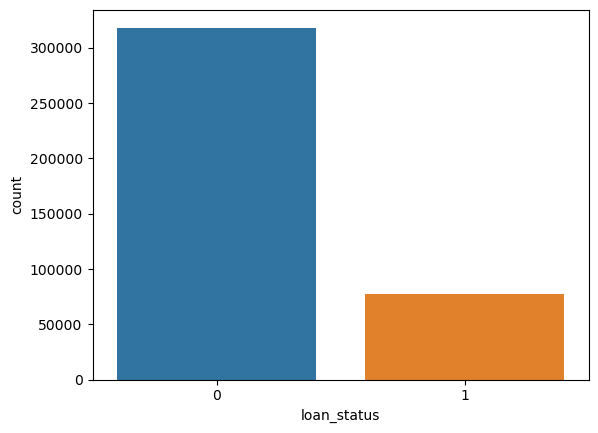

In [60]:
sns.countplot(x='loan_status', data=data)

In [69]:
X = data.drop(columns=['loan_status'])
Y = data['loan_status']

In [70]:
from sklearn.preprocessing import MinMaxScaler

In [71]:
Scaler = MinMaxScaler()

In [73]:
X_scaled = Scaler.fit_transform(X)

In [74]:
X_scaled.shape

(396030, 52)

In [75]:
sm = SMOTE(random_state=42)

In [76]:
X_res, Y_res = sm.fit_resample(X_scaled, Y)
print(X_res.shape)
print(Y_res.shape)
print(Y_res.value_counts())
print(Y_res.value_counts(normalize=True))

(636714, 52)
(636714,)
0    318357
1    318357
Name: loan_status, dtype: int64
0    0.5
1    0.5
Name: loan_status, dtype: float64


In [77]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(df, features):
    """
    Calculate VIF for a set of features in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame
    - features: list of column names (strings)
    
    Returns:
    - DataFrame with features and their corresponding VIF scores
    """
    X = df[features].copy()
    X = add_constant(X)  # Add intercept term for VIF calculation
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data.drop(index=0)  # Drop the constant row


In [78]:
# Convert X_res and Y_res to a pandas DataFrame
X_res_df = pd.DataFrame(X_res, columns=X.columns)
Y_res_df = pd.DataFrame(Y_res, columns=['loan_status'])

# Combine them into a single DataFrame if needed
resampled_data = pd.concat([X_res_df, Y_res_df], axis=1)

In [79]:
calculate_vif(resampled_data, resampled_data.columns).sort_values(by='VIF', ascending=False)

,feature,VIF
1,loan_amnt,54.139277
6,sub_grade,49.415971
4,installment,45.701702
30,purpose_debt_consolidation,26.284911
5,grade,25.822377
3,int_rate,24.175209
29,purpose_credit_card,18.100165
32,purpose_home_improvement,7.006494
37,purpose_other,6.990600
2,term,6.233073


In [80]:
resampled_data.drop(columns=['loan_amnt','sub_grade','installment','grade','int_rate','term','purpose_debt_consolidation','purpose_credit_card','purpose_home_improvement','purpose_other'], inplace=True)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(resampled_data.drop(columns='loan_status'), resampled_data.loan_status, test_size=0.2, random_state=42)
log_reg = LogisticRegression()

In [83]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [84]:
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

In [85]:
y_pred_train = log_reg.predict(X_train)
y_pred_proba_train = log_reg.predict_proba(X_train)[:, 1]

In [86]:
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

Train Accuracy:  0.7803290725227781
Test Accuracy:  0.7813150310578516


In [87]:
confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
confusion_matrix_test = confusion_matrix(y_test, y_pred)
print("Train Confusion Matrix:\n", confusion_matrix_train)
print("Test Confusion Matrix:\n", confusion_matrix_test)

Train Confusion Matrix:
 [[196740  57974]
 [ 53920 200737]]
Test Confusion Matrix:
 [[49063 14580]
 [13268 50432]]


In [88]:
TN = confusion_matrix(y_train, y_pred_train)[0][0]
TP = confusion_matrix(y_train, y_pred_train)[1][1]
FN = confusion_matrix(y_train, y_pred_train)[1][0]
FP = confusion_matrix(y_train, y_pred_train)[0][1]

In [89]:
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
print("Precision:", Precision)
print("Recall:", Recall)

Precision: 0.7759121181550069
Recall: 0.7882642142175553


In [91]:
classification_report_test = classification_report(y_test, y_pred)
print("Test Classification Report:\n", classification_report_test)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78     63643
           1       0.78      0.79      0.78     63700

    accuracy                           0.78    127343
   macro avg       0.78      0.78      0.78    127343
weighted avg       0.78      0.78      0.78    127343



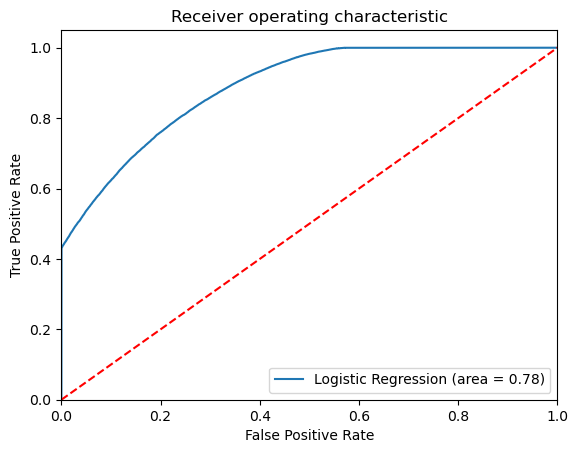

In [92]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [107]:
log_reg_regularized = LogisticRegression(max_iter=10000, random_state=42, C=100, penalty='l2')
log_reg_regularized.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=10000, random_state=42)

In [108]:
print("Train Accuracy: ", accuracy_score(y_train, log_reg_regularized.predict(X_train)))
print("Test Accuracy: ", accuracy_score(y_test, log_reg_regularized.predict(X_test)))

Train Accuracy:  0.7803997479244009
Test Accuracy:  0.7813857063207243


In [105]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [106]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(log_reg_regularized, X_train, y_train, cv=kfold, scoring='accuracy')
print("Cross-validation scores: ", cross_val_scores)
print("Mean cross-validation score: ", cross_val_scores.mean())
print("Standard Deviation of cross-validation scores: ", cross_val_scores.std())

Cross-validation scores:  [0.78051534 0.78096472 0.7807095  0.77835365 0.78095491]
Mean cross-validation score:  0.7802996240152789
Standard Deviation of cross-validation scores:  0.000987227042774325
